# CSX46 - Class Session 10 - Pagerank centrality

In this class session we are going to compute the outgoing-edge PageRank centrality of each gene (vertex) in a human gene regulatory network (a directed graph) from a landmark paper on human gene regulation (Neph et al., Cell, volume 150, pages 1274-1286, 2012; see PDF on Canvas in `Files/Optional Reading`). We will also write our own PageRank function and compare it to the `igraph.Graph.pagerank` method.

Using Pandas `read_csv`, read in the ifle `shared/neph_gene_network.txt`, which has two columns of text (first column is the regulator gene, second column is the target gene), into a data frame. The file has no header and is tab-delimited.  Assign the column names of the dataframe to be `regulator` and `target`, respectively.

Let's load the Python packages that we will need for this exercise

In [1]:
import pandas
import igraph
import numpy
import matplotlib.pyplot
import random

Using `pandas.read_csv`, read the file `shared/neph_gene_network.txt`; name the two columns of the resulting data frame, `regulator` and `target`.

In [2]:
edge_list_neph = pandas.read_csv("shared/neph_gene_network.txt",
                                 sep="\t", 
                                 names=["regulator","target"])

Load the edge-list data into a directed `igraph.Graph` object `neph_graph`, using `igraph.Graph.TupleList`. NOTE: igraph's `igraph.Graph.pagerank` computes only *incoming* pagerank centrality, and we want *outgoing* pagerank centrality. So: *make sure to reverse the columns of the data frame when you input the data frame into `Graph.TupleList` since we want the outgoing pagerank centrality not incoming pagerank centrality.* Print out a summary of the graph, using the `igraph.Graph.summary` method:

In [3]:
neph_graph = igraph.Graph.TupleList(edge_list_neph[["target","regulator"]].values.tolist(), directed=True)
neph_graph.summary()

'IGRAPH DN-- 538 47945 -- \n+ attr: name (v)'

Compute the pagerank centrality measures of all vertices, using `igraph.Graph.pagerank`.  Use the resulting object to initialize a `numpy.array`, `pageranks`.

In [4]:
pageranks = numpy.array(neph_graph.pagerank())

Which vertex has highest pagerank centrality in the gene regulatory network, and what is its pagerank centrality value? (think `numpy.max` and `numpy.argmax`). Get a `VertexSet` sequence using the `igraph.Graph.vs` property, and then index into that sequence using Python indexing:

In [5]:
print(numpy.max(pageranks))
neph_graph.vs[numpy.argmax(pageranks)]

0.00749112688039444


igraph.Vertex(<igraph.Graph object at 0x7f4349d3ec78>, 122, {'name': 'FOS'})

Calculate the in-degree of all vertices in the graph, and scatter plot `log(degree)` vs. `log(pagerank)`.  (Do you see why we used `in` here?  Note the column swapping we did earlier). Note-- you will have to eliminate one vertex that has zero in-degree.

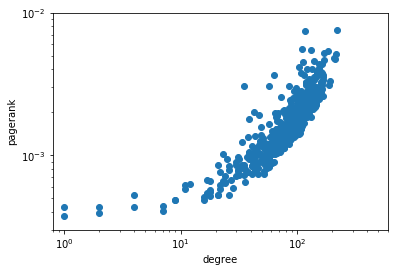

In [6]:
import matplotlib.pyplot
ax = matplotlib.pyplot.gca()
ax.set_xscale("log")
ax.set_yscale("log")
degrees = numpy.array(neph_graph.indegree())
inds_keep = numpy.where(degrees > 0)
ax.scatter(degrees[inds_keep], 
           pageranks[inds_keep])
#ax.scatter(neph_graph.indegree(), pageranks)
matplotlib.pyplot.xlabel("degree")
matplotlib.pyplot.ylabel("pagerank")
matplotlib.pyplot.ylim(3*1e-4, 1e-2)
matplotlib.pyplot.xlim(0.8, 600)
matplotlib.pyplot.show()

See if you can calculate the pagerank centrality yourself, using the matrix inversion (Eq. 7.19 from Newman). Test your function on a small directed graph.

In [7]:
def pagerank(g):
    # N is the number of vertices
    N = len(g.vs)
    
    # alpha is the damping parameter
    alpha = 0.85
    
    # beta = (1-alpha)/N
    beta = (1-alpha)/N
    
    # compute the out-degree of each vertex
    degree_values = g.degree(mode="out")
    
    # get a floating-point adjacency matrix M in the Newman format (take transpose from igraph format)
    M = numpy.matrix(g.get_adjacency().data).transpose().astype(float)
    
    # or each column in 0,N-1:
    for j in range(0,N):
        
        # get the out degree of the vertex as a float
        degree_value = float(degree_values[j])
        
        # if degree is nonzero, normalize the column of M
        if degree_value > 0:
            M[:,j] /= degree_value
        else:
            # set the column to zero
            M[:,j] = 0
            
    # compute pagerank following Newman Eq. 7.19, where M = AD^(-1)
    pr = numpy.linalg.inv(numpy.diag([1.]*N) - alpha * M) * numpy.matrix([beta]*N).transpose()
    
    # normalize pagerank centrality by its sum
    pr /= numpy.sum(pr)
    
    retlist = pr.transpose().tolist()[0]
    return(retlist)

Test out your function on a small 5-vertex Barabasi-Albert graph:

In [11]:
g = igraph.Graph.Barabasi(n=5, m=2) 
import cairo
igraph.drawing.plot(g)
print(pagerank(g))
print(g.pagerank())

[0.2770649250864387, 0.21240875912408758, 0.21240875912408758, 0.14905877833269304, 0.14905877833269304]
[0.2770649250864387, 0.21240875912408758, 0.21240875912408758, 0.14905877833269301, 0.14905877833269304]


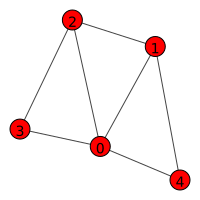

In [13]:
igraph.drawing.plot(g, bbox=[0,0,200,200], vertex_label=list(range(0,5)))